In [2]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import duckdb

In [3]:
# load the data
with h5py.File('../output/full_2017/clusters.h5', 'r') as f:
    clusters = f['clusters'][:]

ids = json.load(open('../output/full_2017/ids.json'))
ids = np.array(ids)
topic_naming = json.load(open('../output/full_2017/topic_naming.json'))

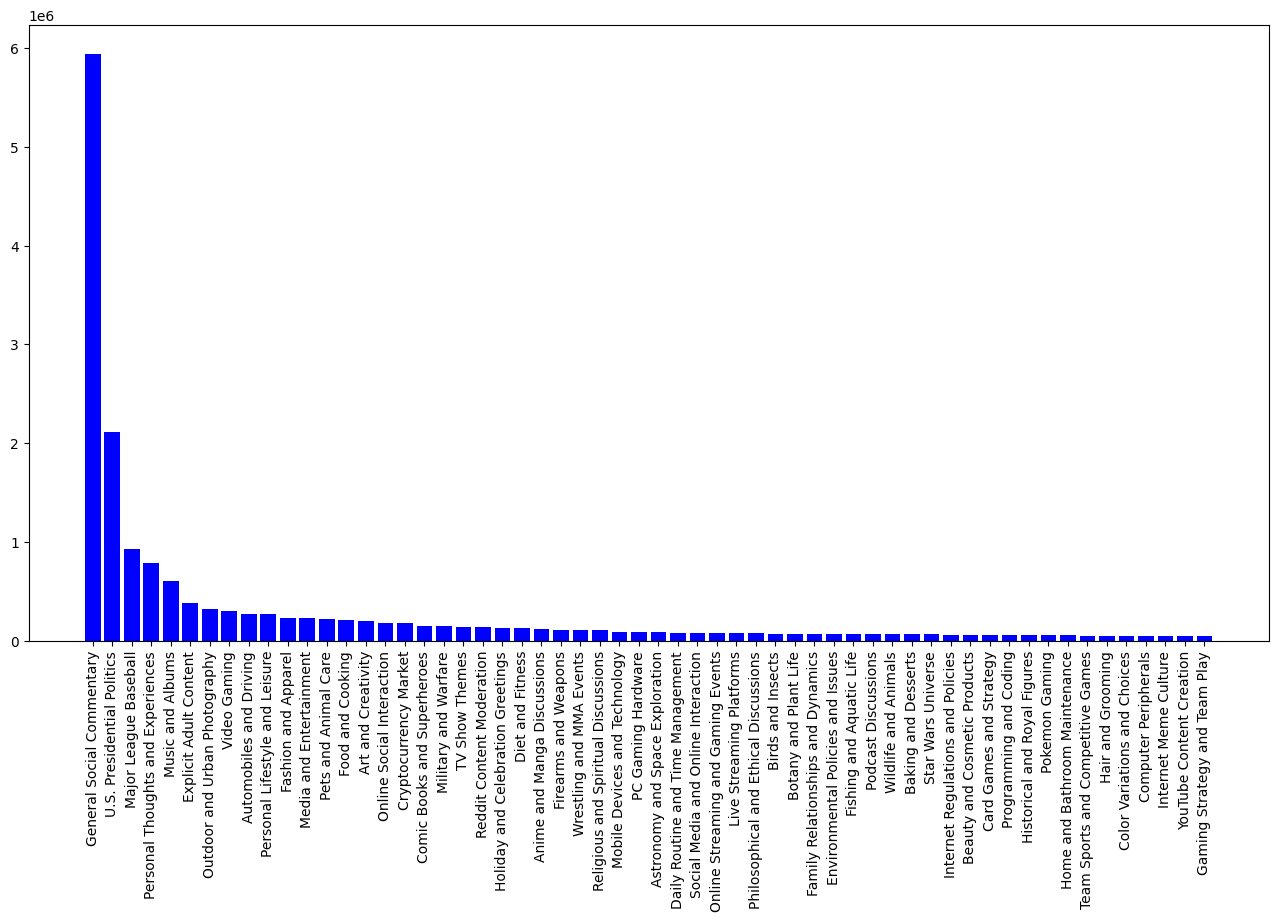

In [4]:
# sort by cluster size
cluster_size = np.bincount(clusters + 1)
sorted_clusters_index = np.argsort(cluster_size)[::-1]
sorted_cluster_size = cluster_size[sorted_clusters_index]
sorted_topic_naming = {k: topic_naming[str(k - 1)] for k in sorted_clusters_index}

plt.figure(figsize=(16, 8))  # Optional: adjusts the size of the figure
plt.bar(list(sorted_topic_naming.values()), sorted_cluster_size, color='blue')  # Creates a bar chart with blue bars

plt.xticks(rotation=90)  # Rotates the x-axis labels
plt.show()

In [8]:
# load all ids corresopnding to a group, see how the number of posts changed over time

def create_database_connection(parquet_directory:str, table_name:str):
    """Create and return a database connection using the provided configuration."""
    files = [f'{parquet_directory}/{file}' for file in os.listdir(parquet_directory)]

    con = duckdb.connect(database=':memory:')

    # Construct a SQL statement to read all files
    query_files = ', '.join(f"'{f}'" for f in files)
    sql_query = f"CREATE TABLE {table_name} AS SELECT author, id, title, selftext, score, num_comments, subreddit, created_utc, media  FROM read_parquet([{query_files}], union_by_name=True)"
    con.execute(sql_query)
    return con

In [5]:
TABLE_NAME = 'submissions'

key = [k for k, v in sorted_topic_naming.items() if v == 'U.S. Presidential Politics'][0]

cluster_ids = np.where(clusters == key)[0] + 1
selected_ids = [ids[i] for i in cluster_ids]

con = create_database_connection('../data/big_test', TABLE_NAME)
placeholders = ','.join(['?'] * len(selected_ids))  # Prepare placeholders for SQL query
query = f"SELECT created_utc FROM {TABLE_NAME} WHERE id IN ({placeholders}) "
cursor = con.execute(query, selected_ids)
posts = cursor.fetchall()
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

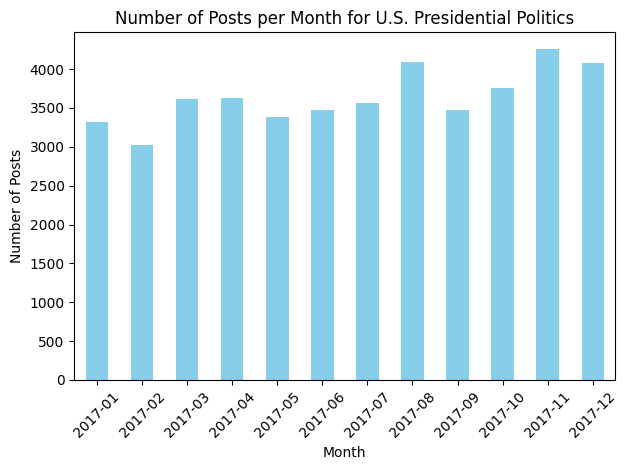

In [7]:
timestamps = [item[0] for item in posts]

# Convert timestamps to datetime
dates = pd.to_datetime(timestamps, unit='s')

# Create a DataFrame
df = pd.DataFrame(dates, columns=['Date'])

# Extract year and month and count occurrences
df['YearMonth'] = df['Date'].dt.to_period('M')  # This groups data by month and year
monthly_counts = df.groupby('YearMonth').size()

# Plotting
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts per Month for U.S. Presidential Politics')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# extract one post for each cluster
TABLE_NAME = 'submissions'

selected_ids = []
topic_ids = {}
for key in np.unique(clusters):
    cluster_ids = np.where(clusters == key)[0]
    middle = len(cluster_ids) // 2
    selected_ids.extend(ids[cluster_ids[middle : middle + 50]]) # get an id in the middle of the cluster
    topic_ids[topic_naming[str(key)]] = ids[cluster_ids]

con = create_database_connection('../data/big_test', TABLE_NAME)
placeholders = ','.join(['?'] * len(selected_ids))  # Prepare placeholders for SQL query
query = f"SELECT  id, subreddit, title, selftext FROM {TABLE_NAME} WHERE id IN ({placeholders}) AND media = FALSE AND LENGTH(title) > 30"
cursor = con.execute(query, selected_ids)
posts = cursor.fetchall()
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [16]:
for post in posts:
    for topic, ids_list in topic_ids.items():
        if post[0] in ids_list:
            print(f'Topic: {topic}')
            break
        
    print(f'Subreddit', post[1])
    print(f'id: {post[0]}')
    print(f'Title: {post[2]}')
    print(f'Selftext: {post[3]}')
    print('---')

Topic: Military and Warfare
Subreddit 2b2t
id: 6n1j0r
Title: The Roosher army is alive and well!
Selftext: 
---
Topic: Military and Warfare
Subreddit The_Donald
id: 6n1j1p
Title: My flight out of Miami had an overnight delay, so I did the only logical thing...
Selftext: 
---
Topic: Military and Warfare
Subreddit aviation
id: 6n1ldp
Title: EA-18G Growler Flying Over the Strait of Juan de Fuca at Sunset
Selftext: 
---
Topic: Military and Warfare
Subreddit MTB
id: 6n1lrq
Title: Best gimbal and gopro setup for the $$?
Selftext: Hi guys,

As the title states, looking to start recording and I'd like to do it right with a gimbal or some sort of stabilizer. What is the best setup for the dollar? I don't need anything too special as far as bells and whistles, I just want some crisp and clear footage.

Thanks!
---
Topic: Military and Warfare
Subreddit pics
id: 6n1mvl
Title: Long Exposure of Airplane Takeoffs and Landings
Selftext: 
---
Topic: Military and Warfare
Subreddit woahdude
id: 6n1n79
Ti

# Distribution of distances limited TF-IDF

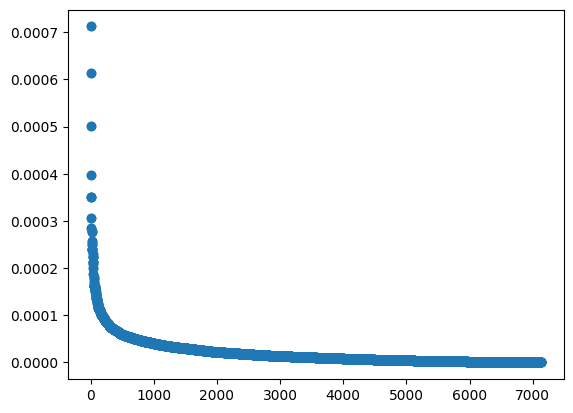

In [30]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 

with h5py.File('../output/testing_pipeline/adjacency_matrix.h5', 'r') as f:
    adjacency_matrix = f['data'][:]

# plot distribution of distances
distances = adjacency_matrix.flatten()
distances = distances[distances != 0]
distances = distances[distances != 1]
distances = list(distances)
distances.sort(reverse = True)
plt.scatter(list(range(len(distances))), distances)
plt.show()

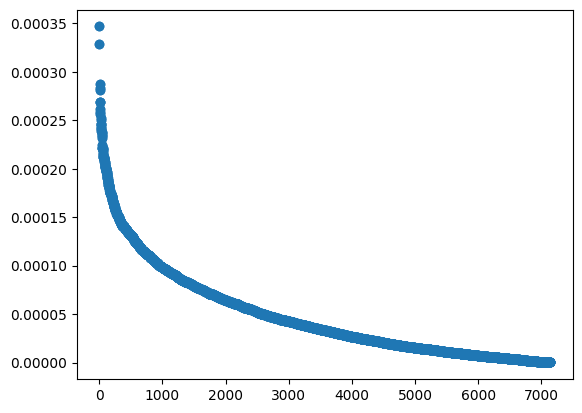

In [35]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 

with h5py.File('../output/testing_pipeline/adjacency_matrix.h5', 'r') as f:
    adjacency_matrix = f['data'][:]

# plot distribution of distances
distances = adjacency_matrix.flatten()
distances = distances[distances != 0]
distances = list(distances)
distances.sort(reverse = True)
plt.scatter(list(range(len(distances))), distances)
# plt.yscale('log')
plt.show()

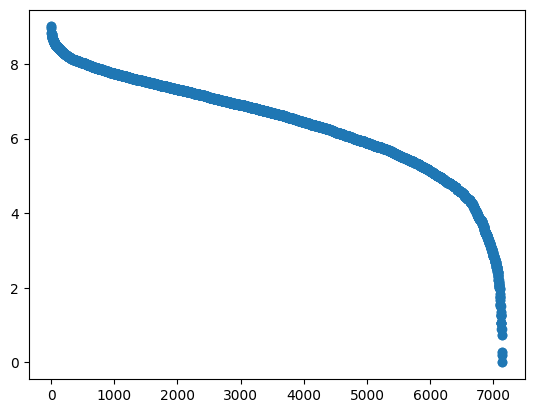

In [45]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 

with h5py.File('../output/testing_pipeline/adjacency_matrix.h5', 'r') as f:
    adjacency_matrix = f['data'][:]

# # plot distribution of distances
# distances
# distances = distances[distances != 0]
distances = list(distances)
distances.sort(reverse = True)
plt.scatter(list(range(len(distances))), distances)
plt.show()


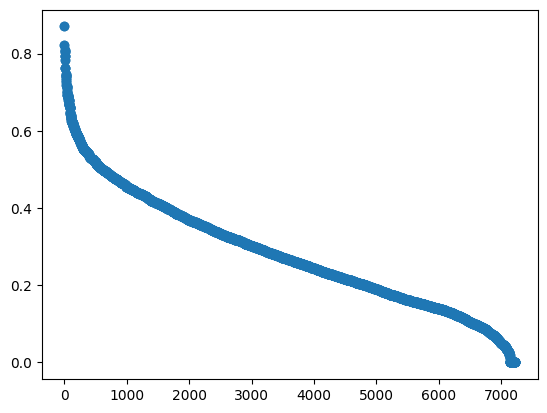

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 

with h5py.File('../output/testing_pipeline/adjacency_matrix.h5', 'r') as f:
    adjacency_matrix = f['data'][:]

# # plot distribution of distances
# distances
# distances = distances[distances != 0]
distances = adjacency_matrix.flatten()
distances = list(distances)
distances.sort(reverse = True)
plt.scatter(list(range(len(distances))), distances)
plt.show()


In [21]:
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

wiki_corpus = api.load('wiki-english-20171001')

texts = []
for n, text in (enumerate(wiki_corpus)): 
    for string in text['section_texts']:
        processed  = simple_preprocess(string)
        if len(processed) > 0:
            texts.append(processed)
    if n > 10: # TODO: remove, I'm considering only the first 10 corpus from wikipedia to speed up the process
        break

dictionary = Dictionary(texts)

In [2]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel
topics = [
     ['human', 'computer', 'system', 'interface'],
     ['graph', 'minors', 'trees', 'eps'], 
     ['bacca']
]

cm = CoherenceModel(topics=topics, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
print(cm.get_coherence())

-7.105015580153772


In [34]:
dict(common_dictionary)

{0: 'computer',
 1: 'human',
 2: 'interface',
 3: 'response',
 4: 'survey',
 5: 'system',
 6: 'time',
 7: 'user',
 8: 'eps',
 9: 'trees',
 10: 'graph',
 11: 'minors'}

In [1]:
import gensim.downloader as api
wiki_corpus = api.load('wiki-english-20171001')


In [6]:
from collections import Counter

def compute_global_topic_diversity(topics):
    # Combine all words from all topics into a single list
    all_words = [word for topic in topics for word in topic]
    
    # Count the frequency of each word
    word_counts = Counter(all_words)
    print(word_counts)
    
    # Find the top 25 most common words
    top_25_words = word_counts.most_common(25)
    
    # Extract only the words from the top 25 tuples (word, count)
    top_words = [word for word, count in top_25_words]
    
    # Count how many unique words are in the top 25 words
    unique_top_words = len(set(top_words))
    
    # Since we are looking at top 25 words, the maximum number of unique words can be 25
    diversity_score = unique_top_words / 25
    
    return diversity_score

# Example usage:
topics = [
    ["apple", "banana", "apple", "orange", "grape", "apple", "banana"],
    ["dog", "cat", "bird", "fish", "cat", "dog", "dog", "parrot", "dog"],
    ["python", "java", "python", "ruby", "c", "java", "javascript", "python", "ruby"],
]

diversity = compute_global_topic_diversity(topics)
print("Diversity score:", diversity)


Counter({'dog': 4, 'apple': 3, 'python': 3, 'banana': 2, 'cat': 2, 'java': 2, 'ruby': 2, 'orange': 1, 'grape': 1, 'bird': 1, 'fish': 1, 'parrot': 1, 'c': 1, 'javascript': 1})
Diversity score: 0.56


In [7]:
from collections import Counter
import math

def compute_document_frequencies(docs):
    # Calculate the document frequency for each word
    df = Counter()
    for doc in docs:
        unique_words = set(doc)
        df.update(unique_words)
    return df

def compute_codocument_frequencies(docs):
    # Calculate the co-document frequency for each pair of words
    codf = Counter()
    for doc in docs:
        unique_words = list(set(doc))
        for i in range(len(unique_words)):
            for j in range(i + 1, len(unique_words)):
                pair = tuple(sorted([unique_words[i], unique_words[j]]))
                codf[pair] += 1
    return codf

def topic_coherence(topics, docs):
    df = compute_document_frequencies(docs)
    codf = compute_codocument_frequencies(docs)
    coherence_scores = []

    for topic in topics:
        M = len(topic)
        if M < 2:
            coherence_scores.append(0)
            continue
        
        C_t = 0
        for m in range(1, M):
            for l in range(m):
                word_m = topic[m]
                word_l = topic[l]
                pair = tuple(sorted([word_m, word_l]))
                D_vm_vl = codf[pair] if pair in codf else 0
                D_vl = df[word_l] if word_l in df else 0
                if D_vl > 0:
                    C_t += math.log((D_vm_vl + 1) / D_vl)
        
        coherence_scores.append(C_t)
    
    return coherence_scores

# Example usage:
posts = [
    ["apple", "banana", "apple", "grape", "orange"],
    ["apple", "dog", "cat", "apple", "orange"],
    ["banana", "dog", "apple", "dog", "parrot", "grape"],
    ["dog", "python", "java", "dog", "ruby", "c"],
]
topics = [
    ["apple", "banana", "orange"],
    ["dog", "cat", "parrot"],
    ["python", "java", "ruby"],
]

coherence = topic_coherence(topics, posts)
print("Coherence scores:", coherence)
import h5py


Coherence scores: [0.0, -0.8109302162163289, 2.0794415416798357]


In [1]:
import h5py
import numpy as np

with h5py.File('../output/testing_pipeline/reddit_data.h5', 'r') as file:
    def visitor_func(name, node):
        if isinstance(node, h5py.Dataset):
            
            print(f"Dataset path: {name}, Dataset shape: {node.shape}, Data type: {node.dtype}")
    file['/'].visititems(visitor_func)

Dataset path: embeddings, Dataset shape: (9597650, 384), Data type: float32
Dataset path: ids, Dataset shape: (9597650,), Data type: object


In [8]:
def save_h5py(data: np.ndarray, file_path: str, db_name: str):
    """
    Save a NumPy array to an HDF5 file without deleting existing datasets.
    """
    with h5py.File(file_path, "a") as file:  # Changed "w" to "a" to prevent deletion of existing data
        # Check if dataset exists and delete if it does to prevent error on creation
        if db_name in file:
            del file[db_name]
        file.create_dataset(db_name, data=data)


save_h5py(np.array([1, 2, 3, 4, 5]), '../random.h5', 'test_1')

In [3]:
import h5py

with h5py.File('../output/testing_pipeline/reddit_data.h5', 'a') as file:

    # Create a new dataset with the same data as the original dataset
    data = file['data'][:]
    

In [4]:
import GPUtil
import logging
import time

def execute_with_gpu_logging(func, *args, **kwargs):
    """
    Executes a function with GPU memory usage logging.
    
    Parameters:
        func (callable): The function to execute.
        *args: Positional arguments to pass to the function.
        **kwargs: Keyword arguments to pass to the function.
        
    Returns:
        The result of the function execution.
    """
    # Log initial GPU memory usage
    gpus = GPUtil.getGPUs()
    initial_mem = {gpu.id: gpu.memoryUsed for gpu in gpus}
    start_time = time.time()

    result = func(*args, **kwargs)

    # Log final GPU memory usage
    gpus = GPUtil.getGPUs()
    final_mem = {gpu.id: gpu.memoryUsed for gpu in gpus}
    end_time = time.time()

    for gpu_id in initial_mem.keys():
        print(f"GPU {gpu_id}: {final_mem}MB of GPU memory were filled after running {func.__name__} and it  took {end_time - start_time:.2f}s")
    
    return result


execute_with_gpu_logging(lambda x: x + 1, 1)  

GPU 0: {0: 490.0, 1: 15.0}MB of GPU memory were filled after running <lambda> and it  took 0.02s
GPU 1: {0: 490.0, 1: 15.0}MB of GPU memory were filled after running <lambda> and it  took 0.02s


2

In [6]:
import cudf
import numpy as np
from cuml import UMAP
import h5py
import time

def get_indices_for_random_h5py_subset(filename: str, dataset_name, subset_fraction: float):
    """Extract data points corresponding to indices"""

    with h5py.File(filename, "r") as file:
        dataset = file[dataset_name]
        total_samples = dataset.shape[0]
        num_samples = int(total_samples * subset_fraction)

        partial_fit_indices = np.random.choice(total_samples, num_samples, replace=False)
        partial_fit_indices.sort()

    return partial_fit_indices, total_samples, num_samples

def load_with_indices_h5py_efficient(file_path: str, db_name: str, indices: np.ndarray) -> np.ndarray:
    """
    Load specific indices from an HDF5 file into a NumPy array using an efficient block loading strategy.
    """
    # Ensure indices are a numpy array for better handling
    indices = np.array(indices)

    # Calculate the range of data to load
    min_idx, max_idx = indices.min(), indices.max()

    # Open the HDF5 file
    with h5py.File(file_path, "r") as file:
        dataset = file[db_name]

        # Load a contiguous block of data from min to max index
        data_block = dataset[min_idx:max_idx+1]  # +1 because max_idx is inclusive

    # Create an array to hold the results
    # Note: 'data_block' starts at 'min_idx', so adjust indices accordingly
    selected_data = data_block[indices - min_idx]

    return selected_data



start = time.time()
indices, total_samples, num_samples = get_indices_for_random_h5py_subset('../output/testing_pipeline/reddit_data.h5', 'embeddings', 0.002)    
print(len(indices), total_samples, num_samples, "time taken", time.time() - start)

start = time.time()
# data = load_with_indices_h5py_efficient('../output/testing_pipeline/reddit_data.h5', 'embeddings', indices)

with h5py.File('../output/testing_pipeline/reddit_data.h5', 'r') as file:
    data = file['embeddings'][:]

data = data[indices]
print(len(data), "time taken", time.time() - start)

# Convert the dataset to a cuDF DataFrame for GPU processing
gpu_data = cudf.DataFrame(data)

# Initialize and fit UMAP
umap = UMAP(n_neighbors=5, n_components=2, random_state=42)
umap_model = umap.fit(gpu_data)

# Transform the dataset
embedding = umap_model.transform(gpu_data)

# Print the result
print("Original Data Shape:", gpu_data.shape)
print("Transformed Data Shape:", embedding.shape)




19195 9597650 19195 time taken 0.1583547592163086
19195 time taken 7.360994577407837
Original Data Shape: (19195, 384)
Transformed Data Shape: (19195, 2)


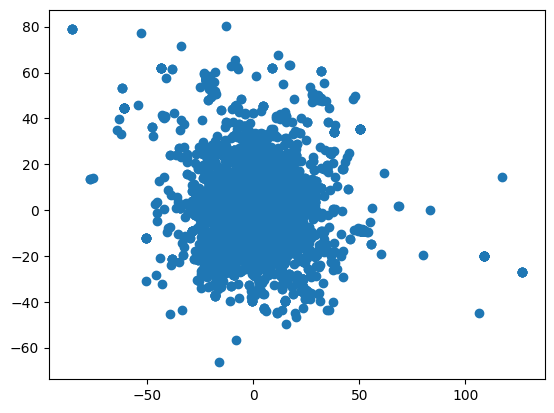

In [46]:
from matplotlib import pyplot as plt

plt.plot(embedding[0], embedding[1], 'o') 